In [1]:
import os
import time

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter

import torchvision

import torchvision.transforms.functional as TF
from PIL import Image

import numpy as np

from model import RAE
from network import *
from config import get_config
from data import batch_elastic_transform, get_dataloader

In [2]:
# mnist 2021-02-07_15-15-51
# shape_color 2021-02-07_15-29-42
# shape_color_size 2021-02-07_15-35-57
# shape_size 2021-02-07_16-13-50

In [3]:
config = get_config(experiment_name='2021-02-07_15-15-51')
config['experiment_name']

'2021-02-07_15-15-51'

In [4]:
model_names = os.listdir(config['model_dir'])
model_names.sort()
model_path = os.path.join(config['model_dir'], model_names[-1])
state = torch.load(model_path)

config = state['config']
model_state_dict = state['model']

model_names[-1]

'00499.pth'

In [5]:
data_loader = get_dataloader(config)

Overriding img_shape and n_prototype_vectors


In [6]:
model = RAE(input_dim=(1,config['img_shape'][0],config['img_shape'][1], config['img_shape'][2]), n_z=config['n_z'], filter_dim=config['filter_dim'], n_prototype_vectors=config['n_prototype_vectors'])
model.load_state_dict(model_state_dict)
model = model.to(config['device'])

In [7]:
def plot_prototypes():
    # decode prototype vectors
    prototype_vectors = model.prototype_layer.prototype_vectors
    prototype_imgs = model.dec.forward(prototype_vectors.reshape((-1,config['n_z'],2,2))).detach().cpu()

    # visualize the prototype images
    n_cols = 3
    n_rows = config['n_prototype_vectors'] // n_cols + 1 if config['n_prototype_vectors'] % n_cols != 0 else config['n_prototype_vectors'] // n_cols
    g, b = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
    for i in range(n_rows):
        for j in range(n_cols):
            if i*n_cols + j < config['n_prototype_vectors']:
                b[i][j].imshow(prototype_imgs[i*n_cols + j].reshape(config['img_shape']).permute(1,2,0).squeeze(), # config['img_shape'][1], config['img_shape'][2]
                                cmap='gray',
                                interpolation='none')
                b[i][j].axis('off')

    # plt.savefig(img_save_path,
    #             transparent=True,
    #             bbox_inches='tight',
    #             pad_inches=0)
    # plt.close()
    plt.show()

In [8]:
def plot_s_mod(s_mod=None):
    imgs = []
    for batch in data_loader:
        imgs = batch[0].to(config['device'])
        break
    n_cols = 3
    examples_to_show = 10

    # decoded image
    encoded = model.enc.forward(imgs[:examples_to_show])
        
    prototype_vectors = model.prototype_layer.prototype_vectors
    
    # decoded softmin weighted prototype
    softmin = torch.nn.Softmin(dim=1)
    p_z = list_of_distances(encoded.view(-1, model.input_dim_prototype), prototype_vectors, norm='l2')
    # std = (config['training_epochs'] - e) / config['training_epochs']
    # p_z += torch.normal(torch.zeros_like(p_z), std)

    if s_mod == None:
        s = softmin(p_z)
    else:
        s = s_mod
        
    softmin_prototype_vector = s@prototype_vectors
    decoded_proto_softmin = model.dec.forward(softmin_prototype_vector.reshape(encoded.shape))

    decoded_proto_softmin = decoded_proto_softmin.detach().cpu()
    imgs = imgs.detach().cpu()

    # compare original images to their reconstructions
    n_rows = 2
    f, a = plt.subplots(n_rows, examples_to_show, figsize=(examples_to_show, n_rows))

    a[0][0].text(0,-2, s='recon softmin proto', fontsize=10)
    a[1][0].text(-1,-0.6, s='softmin weights', fontsize=10)

    for i in range(examples_to_show):

        a[0][i].imshow(decoded_proto_softmin[i].reshape(config['img_shape']).permute(1,2,0).squeeze(), 
                        cmap='gray',
                        interpolation='none')
        a[0][i].axis('off')

        n_cols_proto = n_cols
        n_rows_proto = config['n_prototype_vectors'] // n_cols + 1 if config['n_prototype_vectors'] % n_cols != 0 else config['n_prototype_vectors'] // n_cols

        weights_i = np.zeros((n_rows_proto * n_cols_proto, ))
        weights_i[0:len(s[i])] = s[i].detach().cpu()
        weights_i = weights_i.reshape(n_rows_proto,n_cols_proto)
        weights_i = 1 - weights_i

        a[1][i].imshow(weights_i,
                        interpolation='none')
        a[1][i].axis('off')

    plt.show()

In [9]:
def mod_s_random(n_combs_min=2, n_combs_max=4):
    imgs = []
    for batch in data_loader:
        imgs = batch[0].to(config['device'])
        break
    examples_to_show = 10
    prototype_vectors = model.prototype_layer.prototype_vectors
    encoded = model.enc.forward(imgs[:examples_to_show])
    s_tmp = list_of_distances(encoded.view(-1, model.input_dim_prototype), prototype_vectors, norm='l2')
    
    s_mod = torch.zeros_like(s_tmp)
    for i in range(s_mod.shape[0]):
        n_mod = np.random.randint(n_combs_min,n_combs_max+1)
        for j in range(n_mod):
            idx = np.random.randint(0,s_mod.shape[1])
            s_mod[i][idx] = 1/n_mod
    return s_mod

In [10]:
def mod_s_custom(combs=[[0,1],[1,2]]):
    imgs = []
    for batch in data_loader:
        imgs = batch[0].to(config['device'])
        break
    examples_to_show = 10
    prototype_vectors = model.prototype_layer.prototype_vectors
    encoded = model.enc.forward(imgs[:examples_to_show])
    s_tmp = list_of_distances(encoded.view(-1, model.input_dim_prototype), prototype_vectors, norm='l2')
    
    s_mod = torch.zeros_like(s_tmp)
    for i in range(len(combs)):
        for j in range(len(combs[i])):
            s_mod[i][combs[i][j]] = 1/len(combs[i])
    return s_mod

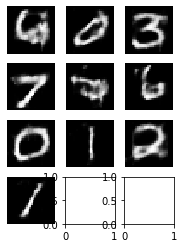

In [11]:
plot_prototypes()

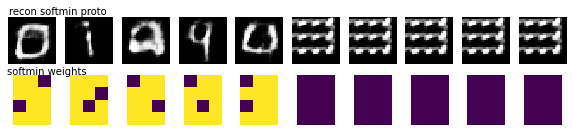

In [12]:
# custom combinations with list of indices list
s_mod = mod_s_custom([[2,6], [5,7], [0,8], [0,7], [0,6]])
# s_mod = mod_s_custom([[2,8], [7,9], [2,5], [1,5], [3,7], [3,9], [5,8]])
plot_s_mod(s_mod)

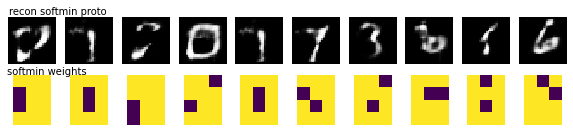

In [13]:
np.random.seed(42)

# random combinations of a minimum of n_combs_min prototypes and maximum of n_combs_max prototypes
s_mod = mod_s_random(n_combs_min=2, n_combs_max=2)
plot_s_mod(s_mod)

In [14]:
# prototype_vectors = model.prototype_layer.prototype_vectors
# combs_all = []
# for i in range(prototype_vectors.shape[0]):
#     for j in range(prototype_vectors.shape[0]):
#         combs_all += [[i,j]]